# Preços de imóveis em João Pessoa

## Introdução

Esta análise se baseia na raspagem de dados na OLX para a pesquisa <a href = "https://www.olx.com.br/brasil?q=im%C3%B3veis%20em%20jo%C3%A3o%20pessoa&o=1">imóveis em joão pessoa</a>, seguida de análise exploratória desses dados.

São empregadas para tanto as seguintes bibliotecas:

- Requests para a realização de requisições HTTP;

- time para intervalos entre requisições;

- random para randomizar intervalos(otimização);

- tqdm para controle de tempo;

- BeautifulSoup para a extração de dados do html das páginas;

- re para a filtragem mais fina desses dados;

- Pandas para manipulação de dados em dataframes.

## 1. Importar bibliotecas

In [1]:
import requests
import time
from random import uniform
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
import re
import pandas as pd
import plotly.express as px

## 2. Web scraping

A primeira parte de nossa análise será a extração de dados por scraping do site da OLX. Para tanto procederemos assim:

1. Inicialmente varremos as páginas de pesquisa à procura dos links de cada um dos produtos;

2. Depois, para cada produto, faremos a raspagem de suas informações em sua própria página.

In [7]:
base_url = 'https://www.olx.com.br/brasil?q=im%C3%B3veis%20em%20jo%C3%A3o%20pessoa'

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

products_links = []
max_consecutive_empty_pages = 3
consecutive_empty_pages = 0
max_pages = 10

pbar = tqdm(total=max_pages, desc="Processando", unit="página", bar_format='{desc}: {n_fmt}/{total_fmt} [Tempo restante: {remaining}]')

for page in range(1, max_pages + 1):
    url = f"{base_url}&o={page}"

    try:
        search_response = requests.get(url, headers=headers)

        if search_response.status_code == 200:
            search_soup = BeautifulSoup(search_response.text, 'html.parser')

            no_results_element = search_soup.find('div', class_='empty-list')
            if no_results_element or 'Nenhum resultado encontrado' in search_response.text:
                pbar.set_postfix_str("Não há mais resultados disponíveis")
                break

            all_links = search_soup.find_all('a', class_='olx-adcard__link')
            
            if all_links:
                consecutive_empty_pages = 0
                for link in all_links:
                    href = link.get('href')
                    if href and href.startswith('http'):
                        products_links.append(href)
            else:
                consecutive_empty_pages += 1
                pbar.set_postfix_str(f"Pág {page} vazia ({consecutive_empty_pages} consecutivas)")
                
                if consecutive_empty_pages >= max_consecutive_empty_pages:
                    pbar.set_postfix_str(f"Parando após {max_consecutive_empty_pages} páginas vazias")
                    break

        elif search_response.status_code == 404:
            pbar.set_postfix_str("Página não encontrada (404)")
            break
        else:
            pbar.set_postfix_str(f"Erro: {search_response.status_code}")
            
    except Exception as e:
        pbar.set_postfix_str(f"Erro: {e}")
        
    pbar.update(1)
    pbar.set_postfix_str(f"Produtos: {len(products_links)}")
    
    time.sleep(uniform(1, 3))

pbar.close()
print(f"Processamento concluído! Total de produtos encontrados: {len(products_links)}")

Processando: 0/10 [Tempo restante: ?]

Processamento concluído! Total de produtos encontrados: 500


Vejamos os dez primeiros links que coletamos:

In [8]:
products_links[0:10]

['https://pb.olx.com.br/paraiba/imoveis/imoveis-na-planta-em-joao-pessoa-1427390473',
 'https://pb.olx.com.br/paraiba/imoveis/imoveis-para-repasse-possuem-62-m-com-02-quartos-em-gramame-joao-pessoa-pb-1433620766',
 'https://pb.olx.com.br/paraiba/imoveis/vendo-imoveis-de-alto-padrao-a-beira-mar-de-intermares-1399963055',
 'https://pb.olx.com.br/paraiba/imoveis/imoveis-na-planta-1424880641',
 'https://pb.olx.com.br/paraiba/imoveis/imoveis-exclusivos-1422666330',
 'https://pb.olx.com.br/paraiba/servicos/imoveis-vende-ou-aluga-casa-apartamento-terreno-1348330489',
 'https://pb.olx.com.br/paraiba/imoveis/alugo-imoveis-1418639984',
 'https://pb.olx.com.br/paraiba/servicos/reforma-de-imoveis-em-joao-pessoa-pisos-pintura-e-outros-acabamentos-1424786399',
 'https://pb.olx.com.br/paraiba/servicos/corretor-de-imoveis-em-joao-pessoa-1357257740',
 'https://pb.olx.com.br/paraiba/servicos/seu-corretor-de-imoveis-perito-avaliador-em-joao-pessoa-1385905983']

São exatamente os dez links que aparecem na primeira página de busca! Vamos agora investigá-los individualmente:

In [9]:
all_products = []

# Criando a barra de progresso tqdm
pbar = tqdm(total=len(products_links), desc="Processando produtos", unit="produto", bar_format='{desc}: {n_fmt}/{total_fmt} [Tempo restante: {remaining}]')

for i, link in enumerate(products_links, 1):
    try:
        product_response = requests.get(link, headers=headers, timeout=10)

        if product_response.status_code == 200:
            product_soup = BeautifulSoup(product_response.text, 'html.parser')

            title_elem = product_soup.find('span', class_='olx-text olx-text--title-medium olx-text--block ad__sc-1l883pa-2 bdcWAn')
            title = title_elem.text.strip() if title_elem else 'Não especificado'

            location_div = product_soup.find('div', id='location')
            if location_div:
                location_elem = location_div.find('span', class_='olx-text olx-text--body-small olx-text--block olx-text--semibold olx-color-neutral-110')
                location = location_elem.text.strip() if location_elem else 'Não especificado'
            else:
                location = 'Não especificado'
            
            price_div = product_soup.find('div', id='price-box-container')
            if price_div:
                price_elem = price_div.find('span', {'data-ds-component': 'DS-Text'})
                price = price_elem.text.strip() if price_elem else 'Não especificado'
                
                product_type_elem = price_div.find('span', class_='olx-badge olx-badge--neutral olx-badge--small olx-badge--rectangle')
                product_type = product_type_elem.text.strip() if product_type_elem else "Não especificado"
            else:
                price = 'Não especificado'
                product_type = "Não especificado"

            product_data = {
                'title': title,
                'location': location,
                'price': price,
                'product_type': product_type,
                'link': link  
            }

            all_products.append(product_data)
            
            # Atualizar informações na barra de progresso
            pbar.set_postfix_str(f"Último: {title[:20]}...")

        else:
            pbar.set_postfix_str(f"Erro: Status {product_response.status_code}")

    except Exception as e:
        pbar.set_postfix_str(f"Erro: {str(e)[:20]}...")
    
    # Atualizar o progresso
    pbar.update(1)
    time.sleep(uniform(1, 3))

pbar.close()
print(f"Extração concluída! Total de produtos: {len(all_products)}")

Processando produtos: 0/500 [Tempo restante: ?]

Extração concluída! Total de produtos: 489


In [10]:
all_products[0:10]

[{'title': 'Imóveis na planta em João Pessoa',
  'location': 'Cabo Branco, João Pessoa, PB, 58045010',
  'price': 'R$ 274.900',
  'product_type': 'Venda',
  'link': 'https://pb.olx.com.br/paraiba/imoveis/imoveis-na-planta-em-joao-pessoa-1427390473'},
 {'title': 'Imóveis para repasse possuem 62 m² com 02 quartos em Gramame - João Pessoa - PB',
  'location': 'João Pessoa, PB, 58068103',
  'price': 'R$ 42.000',
  'product_type': 'Venda',
  'link': 'https://pb.olx.com.br/paraiba/imoveis/imoveis-para-repasse-possuem-62-m-com-02-quartos-em-gramame-joao-pessoa-pb-1433620766'},
 {'title': 'Vendo Imóveis de Alto padrão a Beira Mar de Intermares',
  'location': 'Ipês, João Pessoa, PB, 58028530',
  'price': 'R$ 480.000',
  'product_type': 'Venda',
  'link': 'https://pb.olx.com.br/paraiba/imoveis/vendo-imoveis-de-alto-padrao-a-beira-mar-de-intermares-1399963055'},
 {'title': 'Imóveis na Planta',
  'location': 'Jardim Oceania, João Pessoa, PB, 58037030',
  'price': 'R$ 416.234',
  'product_type': '

Para o restante da análise, incluindo a limpeza e o tratamento dos dados, passamos as informações extraídas para um dataframe, de modo a empregar os artifícios da biblioteca Pandas.

## 3. Limpeza e tratamento

In [132]:
df = pd.DataFrame(all_products)

In [133]:
df.to_csv('data.csv', index = False)

In [134]:
pd.set_option('display.precision', 2)

df

,title,location,price,product_type,link
0,Imóveis na planta em João Pessoa,"Cabo Branco, João Pessoa, PB, 58045010",R$ 274.900,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
1,Imóveis para repasse possuem 62 m² com 02 quar...,"João Pessoa, PB, 58068103",R$ 42.000,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
2,Vendo Imóveis de Alto padrão a Beira Mar de In...,"Ipês, João Pessoa, PB, 58028530",R$ 480.000,Venda,https://pb.olx.com.br/paraiba/imoveis/vendo-im...
3,Imóveis na Planta,"Jardim Oceania, João Pessoa, PB, 58037030",R$ 416.234,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
4,Imoveis exclusivos,"Manaíra, João Pessoa, PB, 58038142",R$ 650.000,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
...,...,...,...,...,...
484,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,"João Pessoa, PB, 58068103",R$ 97.778,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
485,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,"João Pessoa, PB, 58066108",R$ 83.135,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
486,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,"João Pessoa, PB, 58066227",R$ 66.495,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
487,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,"João Pessoa, PB, 58068343",R$ 92.444,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...


In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489 entries, 0 to 488
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         489 non-null    object
 1   location      489 non-null    object
 2   price         489 non-null    object
 3   product_type  489 non-null    object
 4   link          489 non-null    object
dtypes: object(5)
memory usage: 19.2+ KB


Algumas pessoas usaram indevidamente a OLX para disponibilizar seus contatos, a fim de realizar serviços por fora do aplicativo. Podemos remover as linhas correspondentes a esses erros usando verificação por expressão regular na linha de preços, e aproveitar, inclusive, para corrigir a apresentação dos preços para um valor numérico:

In [136]:
# Filtrar para regex correto
price_regex = r'R\$\s*\d{1,3}(?:\.\d{3})*(?:,\d{1,2})?|R\$\s*\d+(?:,\d{1,2})?'
price_mask = df['price'].apply(lambda x: bool(re.search(price_regex, str(x))))
df = df[price_mask]

In [137]:
df

,title,location,price,product_type,link
0,Imóveis na planta em João Pessoa,"Cabo Branco, João Pessoa, PB, 58045010",R$ 274.900,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
1,Imóveis para repasse possuem 62 m² com 02 quar...,"João Pessoa, PB, 58068103",R$ 42.000,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
2,Vendo Imóveis de Alto padrão a Beira Mar de In...,"Ipês, João Pessoa, PB, 58028530",R$ 480.000,Venda,https://pb.olx.com.br/paraiba/imoveis/vendo-im...
3,Imóveis na Planta,"Jardim Oceania, João Pessoa, PB, 58037030",R$ 416.234,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
4,Imoveis exclusivos,"Manaíra, João Pessoa, PB, 58038142",R$ 650.000,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
...,...,...,...,...,...
484,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,"João Pessoa, PB, 58068103",R$ 97.778,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
485,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,"João Pessoa, PB, 58066108",R$ 83.135,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
486,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,"João Pessoa, PB, 58066227",R$ 66.495,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
487,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,"João Pessoa, PB, 58068343",R$ 92.444,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...


In [138]:
df['price'] = (
    df['price']
    .str.replace(r'R\$\s*|[.]', '', regex=True)
    .str.replace(',', '.', regex=False)
    .astype('float64')
)

/tmp/ipykernel_7379/1789600710.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price'] = (


In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 468 entries, 0 to 488
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         468 non-null    object 
 1   location      468 non-null    object 
 2   price         468 non-null    float64
 3   product_type  468 non-null    object 
 4   link          468 non-null    object 
dtypes: float64(1), object(4)
memory usage: 21.9+ KB


In [140]:
df

,title,location,price,product_type,link
0,Imóveis na planta em João Pessoa,"Cabo Branco, João Pessoa, PB, 58045010",274900.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
1,Imóveis para repasse possuem 62 m² com 02 quar...,"João Pessoa, PB, 58068103",42000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
2,Vendo Imóveis de Alto padrão a Beira Mar de In...,"Ipês, João Pessoa, PB, 58028530",480000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/vendo-im...
3,Imóveis na Planta,"Jardim Oceania, João Pessoa, PB, 58037030",416234.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
4,Imoveis exclusivos,"Manaíra, João Pessoa, PB, 58038142",650000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
...,...,...,...,...,...
484,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,"João Pessoa, PB, 58068103",97778.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
485,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,"João Pessoa, PB, 58066108",83135.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
486,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,"João Pessoa, PB, 58066227",66495.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
487,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,"João Pessoa, PB, 58068343",92444.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...


Outra coisa que faremos é transformar a coluna ``location`` em uma coluna contendo apenas os CEPs de cada imóvel (já aproveitamos para deixar o CEP correto para a cidade de João Pessoa):

In [141]:
df = df.rename(columns = {'location': 'cep'})

In [142]:
df

,title,cep,price,product_type,link
0,Imóveis na planta em João Pessoa,"Cabo Branco, João Pessoa, PB, 58045010",274900.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
1,Imóveis para repasse possuem 62 m² com 02 quar...,"João Pessoa, PB, 58068103",42000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
2,Vendo Imóveis de Alto padrão a Beira Mar de In...,"Ipês, João Pessoa, PB, 58028530",480000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/vendo-im...
3,Imóveis na Planta,"Jardim Oceania, João Pessoa, PB, 58037030",416234.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
4,Imoveis exclusivos,"Manaíra, João Pessoa, PB, 58038142",650000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
...,...,...,...,...,...
484,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,"João Pessoa, PB, 58068103",97778.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
485,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,"João Pessoa, PB, 58066108",83135.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
486,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,"João Pessoa, PB, 58066227",66495.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
487,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,"João Pessoa, PB, 58068343",92444.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...


In [143]:
cep_regex = r'(58\d{6})'

df['cep'] = df['cep'].str.extract(cep_regex)
df = df.dropna(subset=['cep']).copy()
df = df.reset_index(drop = True)
df

,title,cep,price,product_type,link
0,Imóveis na planta em João Pessoa,58045010,274900.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
1,Imóveis para repasse possuem 62 m² com 02 quar...,58068103,42000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
2,Vendo Imóveis de Alto padrão a Beira Mar de In...,58028530,480000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/vendo-im...
3,Imóveis na Planta,58037030,416234.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
4,Imoveis exclusivos,58038142,650000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
...,...,...,...,...,...
457,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,58068103,97778.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
458,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,58066108,83135.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
459,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,58066227,66495.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
460,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,58068343,92444.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...


Em ``title``, convém remover vírgulas e pontuações, bem como normalizar o texto para lower case:

In [144]:
df['title'] = df['title'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
df['title'] = df['title'].apply(lambda x: x.lower())

In [145]:
df

,title,cep,price,product_type,link
0,imóveis na planta em joão pessoa,58045010,274900.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
1,imóveis para repasse possuem 62 m² com 02 quar...,58068103,42000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
2,vendo imóveis de alto padrão a beira mar de in...,58028530,480000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/vendo-im...
3,imóveis na planta,58037030,416234.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
4,imoveis exclusivos,58038142,650000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
...,...,...,...,...,...
457,oportunidade única em joao pessoa pb tipo ap...,58068103,97778.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
458,oportunidade única em joao pessoa pb tipo ap...,58066108,83135.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
459,oportunidade única em joao pessoa pb tipo ap...,58066227,66495.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
460,oportunidade única em joao pessoa pb tipo ap...,58068343,92444.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...


Vale a pena testar para duplicatas e valores nulos:

In [146]:
df.duplicated().sum()

np.int64(12)

Removemos:

In [147]:
df.drop_duplicates(inplace = True)
df = df.reset_index(drop = True)

df

,title,cep,price,product_type,link
0,imóveis na planta em joão pessoa,58045010,274900.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
1,imóveis para repasse possuem 62 m² com 02 quar...,58068103,42000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
2,vendo imóveis de alto padrão a beira mar de in...,58028530,480000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/vendo-im...
3,imóveis na planta,58037030,416234.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
4,imoveis exclusivos,58038142,650000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
...,...,...,...,...,...
445,oportunidade única em joao pessoa pb tipo ap...,58068103,97778.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
446,oportunidade única em joao pessoa pb tipo ap...,58066108,83135.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
447,oportunidade única em joao pessoa pb tipo ap...,58066227,66495.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
448,oportunidade única em joao pessoa pb tipo ap...,58068343,92444.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...


In [148]:
df.duplicated().sum()

np.int64(0)

In [149]:
df.isnull().sum()

title           0
cep             0
price           0
product_type    0
link            0
dtype: int64

Tudo certo!

Vamos a uma análise inicial dos nossos dados:

In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         450 non-null    object 
 1   cep           450 non-null    object 
 2   price         450 non-null    float64
 3   product_type  450 non-null    object 
 4   link          450 non-null    object 
dtypes: float64(1), object(4)
memory usage: 17.7+ KB


In [151]:
df.nunique()

title           169
cep             247
price           346
product_type      2
link            450
dtype: int64

In [152]:
df['price'].describe()

count    4.50e+02
mean     6.14e+05
std      1.14e+06
min      8.00e+02
25%      7.24e+04
50%      2.79e+05
75%      7.64e+05
max      1.50e+07
Name: price, dtype: float64

In [153]:
total = df['cep'].value_counts().sum()

df['cep'].value_counts().apply(lambda x: f"{(x/total) * 100}%")

cep
58046110                   4.0%
58037030    3.3333333333333335%
58045010     2.888888888888889%
58068200    2.4444444444444446%
58080020    2.4444444444444446%
                   ...         
58069100    0.2222222222222222%
58084145    0.2222222222222222%
58066108    0.2222222222222222%
58066227    0.2222222222222222%
58066217    0.2222222222222222%
Name: count, Length: 247, dtype: object

Notamos uma dispersão muito grande dos valores dos preços. Para melhorar a visualização, vamos fazer uma extração desses outliers:

In [154]:
df_numeric = df.select_dtypes(include = 'float64')

In [155]:
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)

IQR = Q3 - Q1

print(IQR)

price    691109.75
dtype: float64


In [162]:
print(Q1 - 1.5 * IQR)
print(Q3 + 1.5 * IQR)

price   -964274.38
dtype: float64
price    1.80e+06
dtype: float64


In [170]:
outlier_mask = ((df_numeric < (Q1 - 1.5 * IQR)) | (df_numeric > (Q3 + 1.5 * IQR)))

In [171]:
df_outliers = df[outlier_mask.any(axis = 1)]
df_outliers = df_outliers.reset_index(drop = True)

/tmp/ipykernel_7379/835716349.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [172]:
df_outliers

,title,cep,price,product_type,link
0,apartamento em altiplano com 3 quartos vista p...,58046110,1.56e+06,Venda,https://pb.olx.com.br/paraiba/imoveis/apartame...
1,horizon alliance apartamento em altiplano com ...,58046110,1.20e+06,Venda,https://pb.olx.com.br/paraiba/imoveis/horizon-...
2,falésia apartamento beiramar na praia do seixa...,58045510,9.33e+05,Venda,https://pb.olx.com.br/paraiba/imoveis/falesia-...
3,joão pessoa apartamento com 4 quartos bessa i,58035300,8.10e+05,Venda,https://pb.olx.com.br/paraiba/imoveis/joao-pes...
4,joão agripino alugo apartamento alto padrão m...,58034575,7.00e+03,Aluguel,https://pb.olx.com.br/paraiba/imoveis/joao-agr...
5,apartamento para venda em joão pessoa bessa 2 ...,58035110,4.50e+05,Venda,https://pb.olx.com.br/paraiba/imoveis/apartame...
6,apartamento para venda em joão pessoa bessa 3 ...,58037603,1.30e+06,Venda,https://pb.olx.com.br/paraiba/imoveis/apartame...
7,apartamento para venda em joão pessoa bessa 3 ...,58036845,1.14e+06,Venda,https://pb.olx.com.br/paraiba/imoveis/apartame...
8,apartamento para venda em joão pessoa manaira ...,58038000,6.30e+05,Venda,https://pb.olx.com.br/paraiba/imoveis/apartame...
9,apartamento para venda em joão pessoa manaira ...,58038310,8.42e+05,Venda,https://pb.olx.com.br/paraiba/imoveis/apartame...


In [177]:
df = df[~outlier_mask.any(axis = 1)]
df = df.reset_index(drop = True)

/tmp/ipykernel_7379/86199651.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [178]:
df

,title,cep,price,product_type,link
0,imóveis na planta em joão pessoa,58045010,274900.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
1,imóveis para repasse possuem 62 m² com 02 quar...,58068103,42000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
2,vendo imóveis de alto padrão a beira mar de in...,58028530,480000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/vendo-im...
3,imóveis na planta,58037030,416234.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
4,imoveis exclusivos,58038142,650000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
...,...,...,...,...,...
325,oportunidade única em joao pessoa pb tipo ap...,58068103,97778.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
326,oportunidade única em joao pessoa pb tipo ap...,58066108,83135.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
327,oportunidade única em joao pessoa pb tipo ap...,58066227,66495.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
328,oportunidade única em joao pessoa pb tipo ap...,58068343,92444.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...


In [182]:
df.describe(include = 'float64')

,price
count,3.30e+02
mean,3.53e+05
std,3.99e+05
min,8.00e+02
25%,7.01e+04
50%,8.52e+04
75%,6.07e+05
max,1.80e+06


Vejamos quanto de nossa análise abrangeu entre vendas e aluguéis:

In [233]:
df['product_type'].value_counts()

product_type
Venda      328
Aluguel      2
Name: count, dtype: int64

Para esta análise, ocupar-nos-emos das vendas apenas:

In [234]:
df = df[df['product_type'] == 'Venda']

## 4. Visualização

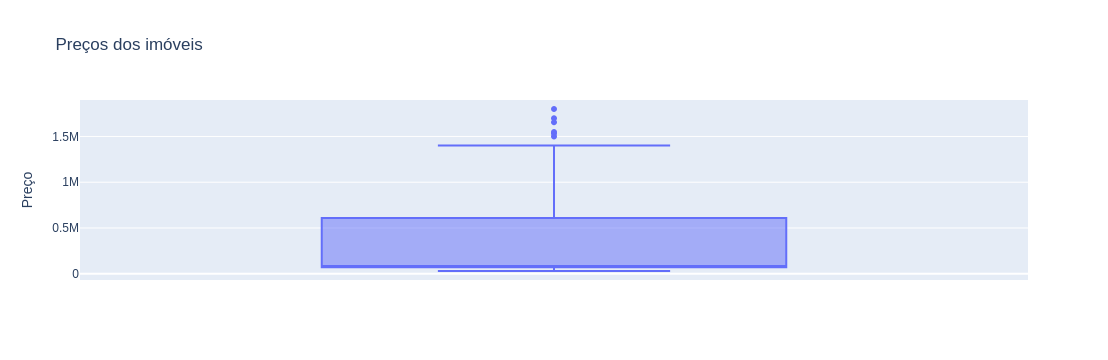

In [235]:
box_price = px.box(
    df,
    y = 'price',
    title = 'Preços dos imóveis',
)

box_price.update_layout(
    yaxis_title = 'Preço'
)

box_price.show()

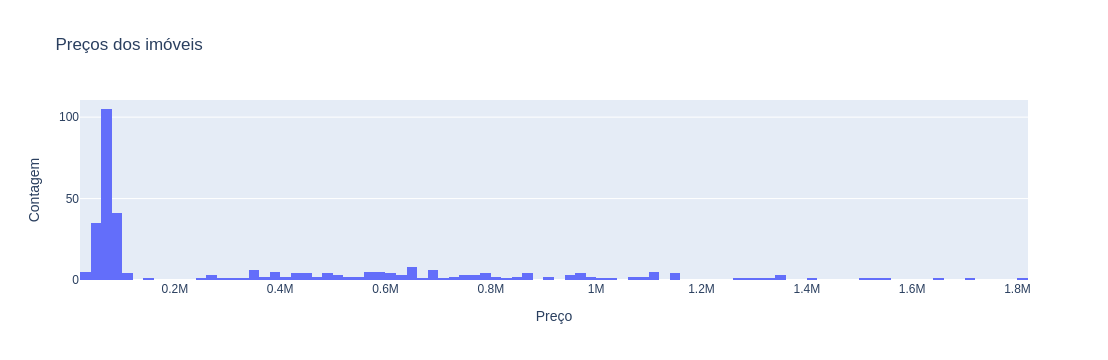

In [279]:
hist_price = px.histogram(
    df['price'].value_counts().reset_index(),
    x = 'price',
    y = 'count',
    nbins = 100,
    title = 'Preços dos imóveis',
)

hist_price.update_layout(
    xaxis_title = 'Preço',
    yaxis_title = 'Contagem'
)

hist_price.show()